In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

series_name = "sim/test/return"
file_name = "arr.csv" # TODO: replace
data_dict_outer = {}
data_dict = {}
env = 'dmc_cup_catch'

In [19]:
def parse_tf_events_file(folder_name, series_name=series_name):
    if not folder_name[-1] == "/":
        folder_name = folder_name + "/"
    all_files = os.listdir(folder_name)
    file_name = [f for f in all_files if "events.out.tfevents" in f][0]
    file_name = folder_name + file_name
    eval_returns = []
    for e in summary_iterator(file_name):
        for v in e.summary.value:
            if v.tag == series_name:
#                 print(dir(v))
                x = tf.make_ndarray(v.tensor)
#                 print(x, v.simple_value)
                eval_returns.append([e.step,x])
    all_data = pd.DataFrame(data=eval_returns, columns=["Steps","Returns"])
    return all_data

def parse_csv_file(file_name):
    return pd.read_csv(file_name).values[:,2]

def plot(file_names, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
         load_from_tb=False, base_dir=None, file_name=file_name, avg_every=None):
    for run_name in file_names:
        if load_from_tb:
            if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name)
            csv = parse_tf_events_file(full_file_name)
        else:
            if base_dir is not None:
                full_file_name = os.path.join(base_dir, run_name, file_name)
            csv = parse_csv_file(full_file_name)
        if avg_every:
            csv = csv.rolling(window=avg_every).mean()
        
        x = np.array(range(len(csv))) * scale
        plt.plot(x, csv)
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1000)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()

    
def plot_avg(file_names_list, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, file_name=file_name, avg_every=None, clip_to=None):
    for file_names, base_dir in file_names_list:
        runs = []
        steps = None
        for run_name in file_names:
            if load_from_tb:
                if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name)
#                 print("FULL FILE NAME", full_file_name)
                out = parse_tf_events_file(full_file_name)
                csv = pd.DataFrame(data=out['Returns'].values, columns=['Returns'])
                steps = out['Steps'].values.astype(int)/1000
#                 print(steps.shape)
            else:
                if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name, file_name)
                csv = parse_csv_file(full_file_name)
            if avg_every:
                csv = csv.ewm(span=avg_every).mean()#(window=avg_every).mean()
            runs.append(csv)
        if len(runs) > 0:
            min_len = min([len(run) for run in runs])
            if clip_to is not None:
                min_len = min(clip_to, min_len)
                if steps is not None:
                    try:
#                         print("SH", steps.shape)
    #                     print("SH2", np.where(steps > clip_to * 10).shape)
#                         print("SH3", np.where(steps > clip_to * 10)[0].shape)
                        min_len = np.where(steps > clip_to * 10)[0][0]
#                         print("min_len", min_len)
                
                    except:
                        print("??")
            
            runs = [run[:min_len] for run in runs]
            mean_arr = np.mean(np.stack(runs), axis=0)
            std_arr = np.std(np.stack(runs), axis=0)

            if len(mean_arr.shape) > 1:
                mean_arr = mean_arr[:, 0]
                std_arr = std_arr[:, 0]
            if steps is not None:
                x = steps[:min_len]
            else:
#                 print("BAD")
                x = np.array(range(len(mean_arr))) * scale
#             print("plotting", file_names, len(x))
            plt.plot(x, mean_arr)
            plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
        else:
            print("no runs for", full_file_name)
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()


In [14]:
ratio_dict = {
    "1:1": 0,
    "10:1": 1,
    "100:1": 2,
    "No real": 3,
}
outer_loop_dict = {
    "No outer loop": 1 ,
    "Outer loop 1": 2,
    "Outer loop 2": 3,
}
seed_dict = {
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
}


condition_dict = {
    "Condition 1: Accurate, precise (correct mass)": 0,
    "Condition 2: Accurate, imprecise (correct mass)": 1,
    "Condition 3: Inaccurate, precise (small mass)": 2,
    "Condition 4: Inaccurate, imprecise* (small mass)": 3,
    "Condition 5: Inaccurate, imprecise (small mass)": 4,
    "Condition 6: Inaccurate, precise (large mass)": 5,
    "Condition 7: Inaccurate, imprecise* (large mass)": 6,
    "Condition 8: Inaccurate, imprecise (large mass)": 7,
}

dr_dict = {
    "mass_only": 0,
    "all": 1,
}


def filter_by_dr(files, condition):
    value = str(dr_dict[condition])
    return list(filter(lambda x: x[0] == value, files))


def filter_by_ratio(files, condition):
    value = str(ratio_dict[condition])
    return list(filter(lambda x: x[2] == value, files))

def filter_by_outer_loop(files, condition):
    value = str(outer_loop_dict[condition])
    return list(filter(lambda x: x[1] == value, files))

def filter_by_seed(files, condition):
    value = str(seed_dict[condition])
    return list(filter(lambda x: x[5] == value, files))

def filter_by_condition(files, condition):
    value = str(condition_dict[condition])
    return list(filter(lambda x: x[3] == value, files))

def filter_by_env(files):
    return list(filter(lambda x: env in x, files))

# Compare Outer Loop

In [4]:
base_path_0 = "/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/" # TODO: replace
base_path_1 = "/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer" # TODO: replace
base_path_2 = "/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/" # TODO: replace

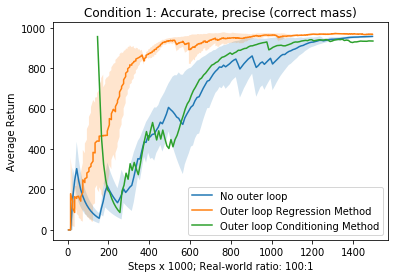

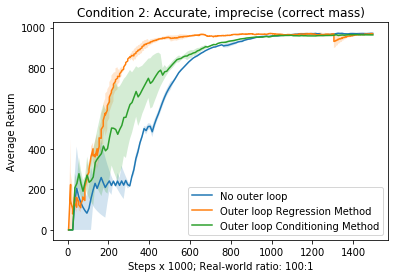

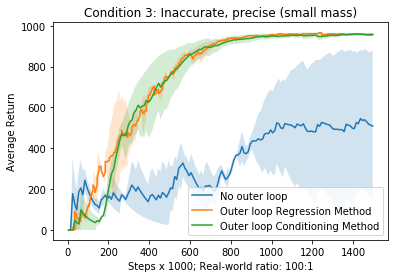

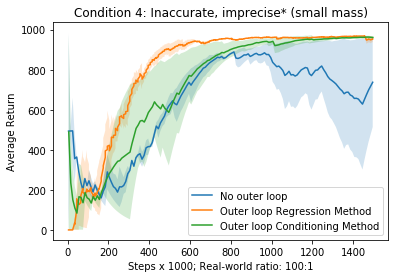

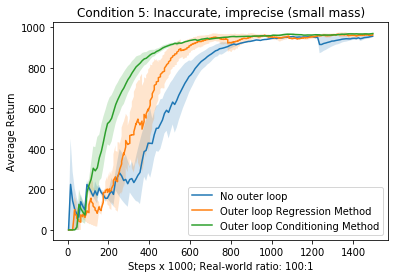

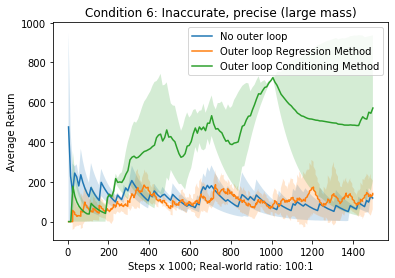

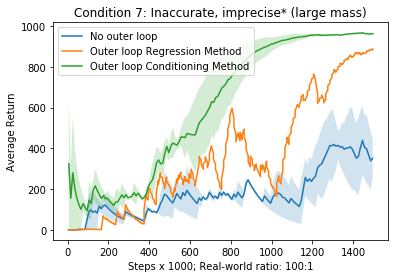

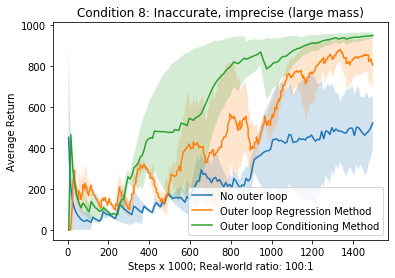

In [20]:
data_dict_outer = {}
ratio = "100:1" # or we could loop through multiple values for this
load_from_tb = True # TODO: change this if we have an actual TB directory!
files_0 = filter_by_dr(os.listdir(base_path_0), "mass_only")
files_1 = filter_by_dr(os.listdir(base_path_1), "mass_only")
files_2 = filter_by_dr(os.listdir(base_path_2), "mass_only")
# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition + ratio in data_dict_outer:
        plot_files, labels = data_dict
#         print(plot_files, labels)
    else:
        
        condition_files_0 = filter_by_condition(files_0, condition)
        condition_files_1 = filter_by_condition(files_1, condition)
        condition_files_2 = filter_by_condition(files_2, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        
        ratio_files_0 = filter_by_ratio(condition_files_0, ratio)
        ratio_files_1 = filter_by_ratio(condition_files_1, ratio)
        ratio_files_2 = filter_by_ratio(condition_files_2, ratio)
        no_outer_files_1 = filter_by_outer_loop(ratio_files_1, "No outer loop")
        outer_files_1 = filter_by_outer_loop(ratio_files_1, "Outer loop 1")
        outer_files_2 = filter_by_outer_loop(ratio_files_2, "Outer loop 2")
#         print(outer_files_2)
        outer_files_2 = [o for o in outer_files_2 if '_1-' in o and o[0] == '0']
        plot_files = [(no_outer_files_1, base_path_1), 
                      (outer_files_1, base_path_1),
                      (outer_files_2, base_path_2)]
        labels = ["No outer loop", "Outer loop Regression Method", "Outer loop Conditioning Method"]
        data_dict_outer[condition + ratio] = (plot_files, labels)
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
#     print(plot_files)
    plot_avg(plot_files, labels, "Steps x 1000; Real-world ratio: " + ratio, "Average Return", condition, 
             save_name=f"outer_{condition}_{ratio}.png",
             avg_every=25, load_from_tb=load_from_tb, scale=100, clip_to=150)

# penguin

[(['0120', '01200'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0320_0_1-dmc_cup_catch-dreamer', '1320_0_0-dmc_cup_catch-dreamer', '0320_0_2-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(216,)
(166,)
SH (166,)
SH3 (0,)
??
(429,)
(367,)
SH (367,)
SH3 (0,)
??
(186,)
(32,)
(0,)
SH (0,)
SH3 (0,)
??


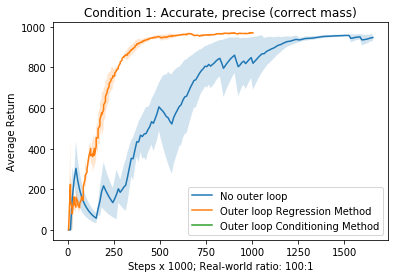

[(['01210', '0121'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0321_1_1-dmc_cup_catch-dreamer', '1321_0-dmc_cup_catch-dreamer', '0321_0_2-dmc_cup_catch-dreamer', '0321_0_1-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(154,)
(181,)
SH (181,)
SH3 (0,)
??
(429,)
(367,)
SH (367,)
SH3 (0,)
??
(200,)
(0,)
(200,)
(200,)
SH (200,)
SH3 (0,)
??


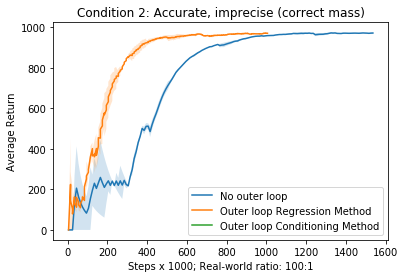

[(['01220', '0122'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0322_1_1-dmc_cup_catch-dreamer', '0322_0_2-dmc_cup_catch-dreamer', '0322_0_1-dmc_cup_catch-dreamer', '1322_0_0-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(500,)
(179,)
SH (179,)
SH3 (0,)
??
(429,)
(367,)
SH (367,)
SH3 (0,)
??
(200,)
(200,)
(200,)
(31,)
SH (31,)
SH3 (0,)
??


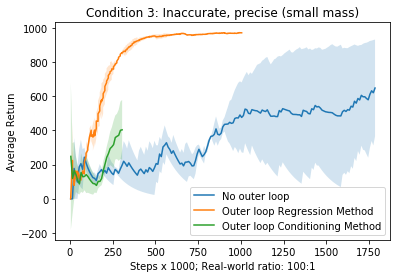

[(['01230', '0123'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0323_0_1-dmc_cup_catch-dreamer', '1323_0_0-dmc_cup_catch-dreamer', '0323_1_1-dmc_cup_catch-dreamer', '1323_0_2-dmc_cup_catch-dreamer', '1323_1_0-dmc_cup_catch-dreamer', '0323_0_2-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(169,)
(178,)
SH (178,)
SH3 (0,)
??
(429,)
(367,)
SH (367,)
SH3 (0,)
??
(200,)
(79,)
(200,)
(0,)
(128,)
(200,)
SH (200,)
SH3 (0,)
??


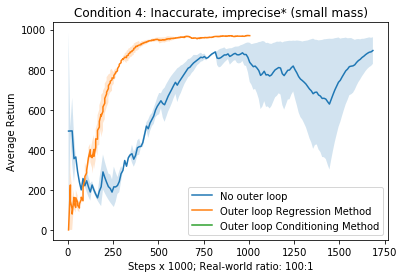

[(['0124', '01240'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0324_1_1-dmc_cup_catch-dreamer', '0324_0_2-dmc_cup_catch-dreamer', '0324_0_1-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(182,)
(167,)
SH (167,)
SH3 (0,)
??
(429,)
(367,)
SH (367,)
SH3 (0,)
??
(200,)
(200,)
(200,)
SH (200,)
SH3 (0,)
??


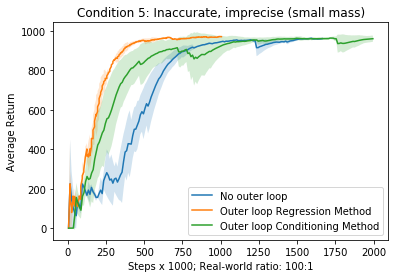

[(['01250', '0125'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['02210', '0221'], '/home/olivia/Sim2Real/sim2real2simYD/sim2real2sim/logdir/dmc_cup_catch/dreamer'), (['0325_0_1-dmc_cup_catch-dreamer', '0325_0_3-dmc_cup_catch-dreamer', '0325_1_1-dmc_cup_catch-dreamer', '0325_0_2-dmc_cup_catch-dreamer'], '/home/olivia/Sim2Real/Sim2/sim2real2sim/logdir/')]
(170,)
(217,)
SH (217,)
SH3 (17,)
min_len 200


ValueError: all input arrays must have the same shape

In [6]:
data_dict_outer = {}
ratio = "100:1" # or we could loop through multiple values for this
load_from_tb = True # TODO: change this if we have an actual TB directory!
files_0 = os.listdir(base_path_0)
files_1 = os.listdir(base_path_1)
files_2 = os.listdir(base_path_2)
# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition + ratio in data_dict_outer:
        plot_files, labels = data_dict
        print(plot_files, labels)
    else:
        
        condition_files_0 = filter_by_condition(files_0, condition)
        condition_files_1 = filter_by_condition(files_1, condition)
        condition_files_2 = filter_by_condition(files_2, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        
        ratio_files_0 = filter_by_ratio(condition_files_0, ratio)
        ratio_files_1 = filter_by_ratio(condition_files_1, ratio)
        ratio_files_2 = filter_by_ratio(condition_files_2, ratio)
        no_outer_files_1 = filter_by_outer_loop(ratio_files_1, "No outer loop")
        outer_files_2 = filter_by_outer_loop(ratio_files_2, "Outer loop 2")
        plot_files = [(no_outer_files_1, base_path_1), 
                      (outer_files_1, base_path_1),
                      (outer_files_2, base_path_2)]
        labels = ["No outer loop", "Outer loop Regression Method", "Outer loop Conditioning Method"]
        data_dict_outer[condition + ratio] = (plot_files, labels)
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    print(plot_files)
    plot_avg(plot_files, labels, "Steps x 1000; Real-world ratio: " + ratio, "Average Return", condition, 
             save_name=f"outer_{condition}_{ratio}.png",
             avg_every=25, load_from_tb=load_from_tb, scale=100, clip_to=200)

# penguin